# Setup



In [1]:
# import libraries

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import time

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

<ipython-input-1-56816b979ef4>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# load data

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/GraphML Data/netflix_titles.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# feature engineering

# convert to datetime
#df["date_added"] = pd.to_datetime(df['date_added'])

# build real lists from string lists
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

In [4]:
df.shape

(6234, 16)

In [5]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,directors,categories,actors,countries
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,"[Richard Finn, Tim Maltby]","[Children & Family Movies, Comedies]","[Alan Marriott, Andrew Toth, Brian Dobson, Col...","[United States, India, South Korea, China]"
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,[],[Stand-Up Comedy],[Jandino Asporaat],[United Kingdom]
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",[],[Kids' TV],"[Peter Cullen, Sumalee Montano, Frank Welker, ...",[United States]
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,[],[Kids' TV],"[Will Friedle, Darren Criss, Constance Zimmer,...",[United States]
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,[Fernando Lebrija],[Comedies],"[Nesta Cooper, Kate Walsh, John Michael Higgin...",[United States]


# TF-IDF

In [6]:
# TF-IDF is used to take the descriptions into account as features

"""
WIKIPEDIA:

In information retrieval, tf–idf (also TF*IDF, TFIDF, TF–IDF, or Tf–idf),
  short for term frequency–inverse document frequency, is a measure of importance of a word to a document
  in a collection or corpus, adjusted for the fact that some words appear more frequently in general.
"""
# calculate top 5 most similar descriptions and build as a node

'\nWIKIPEDIA:\n\nIn information retrieval, tf–idf (also TF*IDF, TFIDF, TF–IDF, or Tf–idf),\n  short for term frequency–inverse document frequency, is a measure of importance of a word to a document\n  in a collection or corpus, adjusted for the fact that some words appear more frequently in general.\n'

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build tf-idf matrix with the descriptions
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,       # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names_out()

# print the centers of the clusters
# for i in range(0,k):
#     word_list=[]
#     print("cluster%d:"% i)
#     for j in centers[i,:10]:
#         word_list.append(terms[j])
#     print(word_list)

request_transform = vector.transform(df['description'])

# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform)

df['cluster'].value_counts().head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


,count
cluster,
22,4649
69,926
99,180
36,141
10,79


In [8]:
def find_similar_desc_matrix(tfidf_matrix, index, top_n = 5):
    """
    Use cosine similarity to find the top n most similar descriptions to the given index.
    """
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

# Build Graph

In [9]:
"""
  Heterogeneous Graph

    Nodes can represent:

    Movies
    Person (i.e. Actors/Directors)
    Genres
    Countries
    Sim(title) top 5 most similar movie descriptions

    Edges can represent:

    ACTED_IN : relation between an actor and a movie
    CAT_IN : relation between a category and a movie
    DIRECTED : relation between a director and a movie
    COU_IN : relation between a country and a movie
"""

'\n  Heterogeneous Graph\n\n    Nodes can represent:\n\n    Movies\n    Person (i.e. Actors/Directors)\n    Genres\n    Countries\n    Sim(title) top 5 most similar movie descriptions\n\n    Edges can represent:\n\n    ACTED_IN : relation between an actor and a movie\n    CAT_IN : relation between a category and a movie\n    DIRECTED : relation between a director and a movie\n    COU_IN : relation between a country and a movie\n'

In [10]:

G = nx.Graph(label="Movie")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="Movie",mtype=rowi['type'],rating=rowi['rating'])
    for element in rowi['actors']:
        G.add_node(element,label="Person")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="Genre")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="Person")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")

    indices = find_similar_desc_matrix(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))


 iter 0 -- 0.006566524505615234 seconds --
 iter 1000 -- 3.8645267486572266 seconds --
 iter 2000 -- 7.60033392906189 seconds --
 iter 3000 -- 12.206768035888672 seconds --
 iter 4000 -- 16.48431921005249 seconds --
 iter 5000 -- 20.14537286758423 seconds --
 iter 6000 -- 23.944177627563477 seconds --
 finish -- 25.363717555999756 seconds --


In [11]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
                sub_graph.add(e)
    return list(sub_graph)

In [12]:
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="Movie":
            colors.append('blue')
        elif G.nodes[e]['label']=="Person":
            colors.append('red')
        elif G.nodes[e]['label']=="Genre":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()

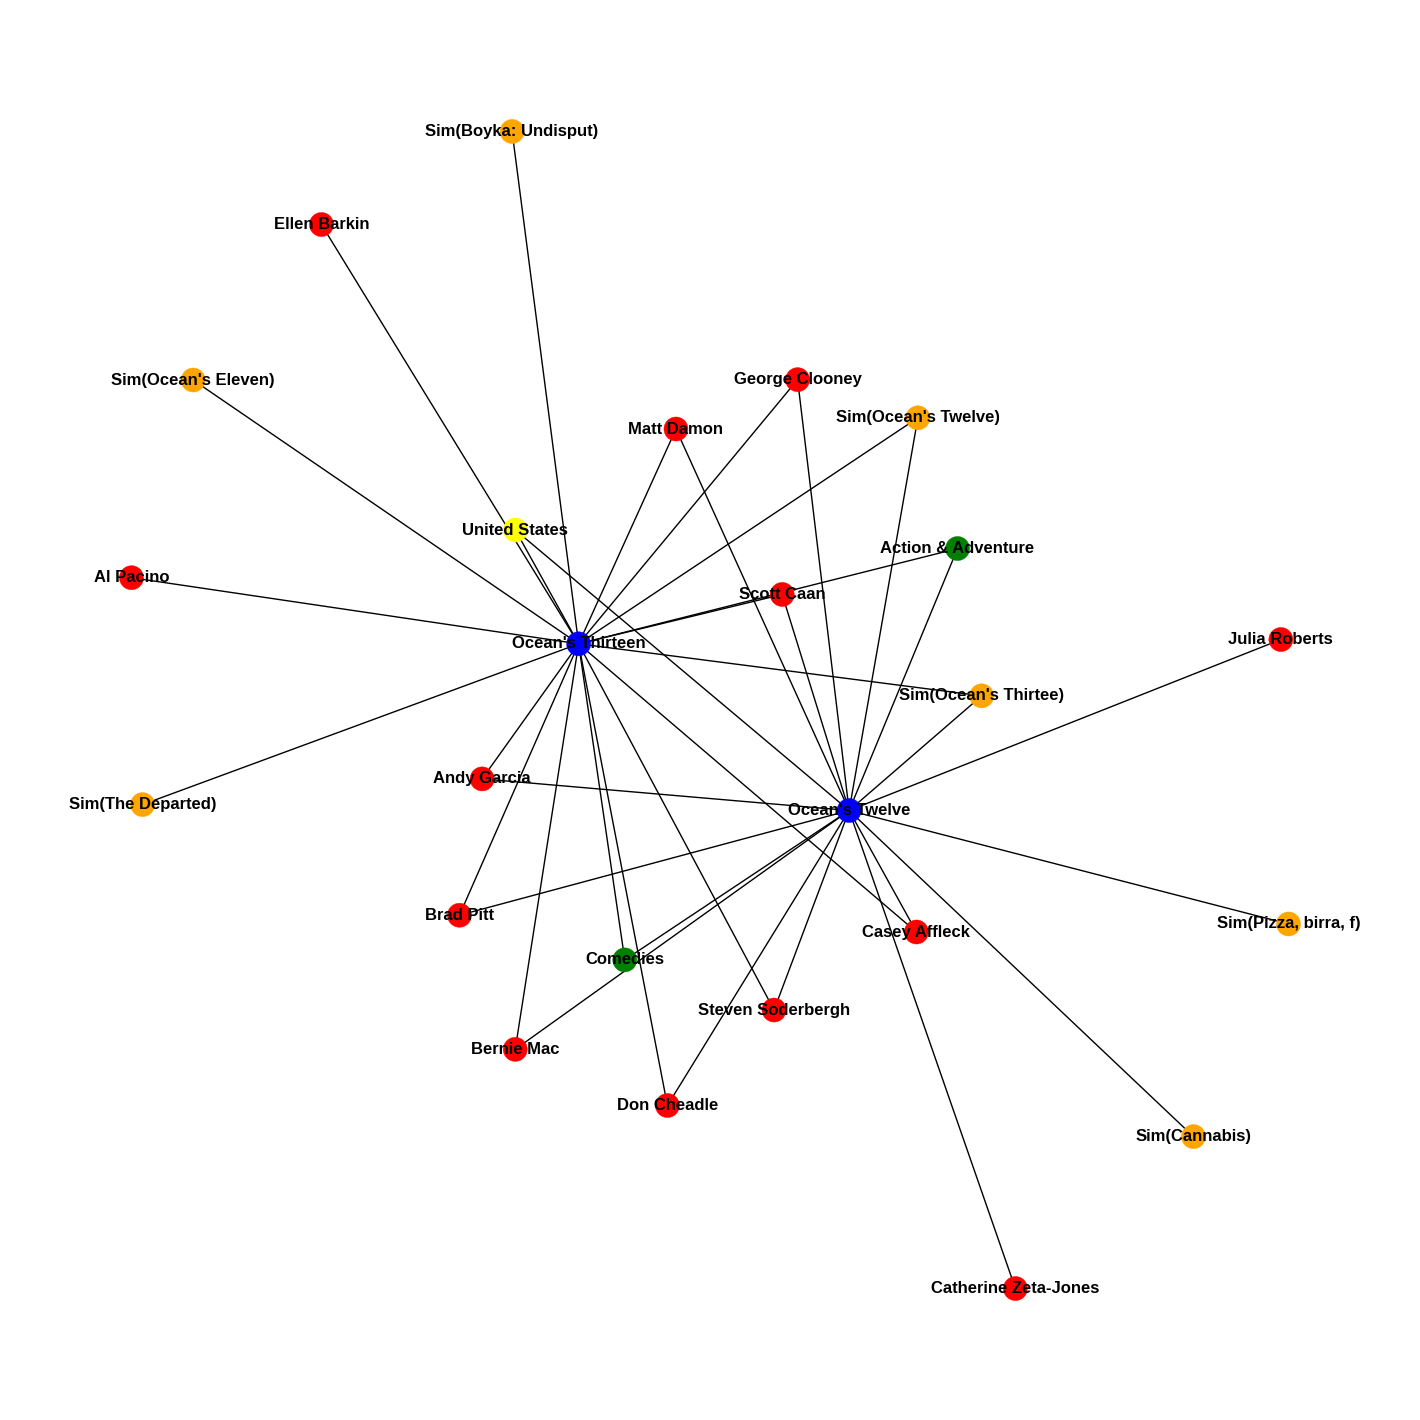

In [13]:
list_in=["Ocean's Twelve","Ocean's Thirteen"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

# Make Recommendations

In [14]:
"""
Use graph distance make recommendations similar to the input movie

Graph locality allows us to this:
  Nodes which are more similar tend to be closer to one another in the graph (
  (they share common edges, have fewer num edges between, etc.)

To make recommendation:
  Explore the local neighborhood of the input movie (1-hop, 2-hop neighbors)
  Use Adamic-Adar Index to calculate the closeness of nodes and how impactful their shared neighbors are between
  WIKI:
    It is defined as the sum of the inverse logarithmic degree centrality of the neighbours shared by the two nodes.

  Essentially a graph version of TF-IDF, where common links between two nodes are weighted more heavily if
    the shared node has fewer neighbors. Inversely, if two nodes share a common neighbor, but that neighbor has a
    large number of other neighbors as well, this connection is weighed less heavily.
"""

'\nUse graph distance make recommendations similar to the input movie\n\nGraph locality allows us to this:\n  Nodes which are more similar tend to be closer to one another in the graph (\n  (they share common edges, have fewer num edges between, etc.)\n\nTo make recommendation:\n  Explore the local neighborhood of the input movie (1-hop, 2-hop neighbors)\n  Use Adamic-Adar Index to calculate the closeness of nodes and how impactful their shared neighbors are between\n  WIKI:\n    It is defined as the sum of the inverse logarithmic degree centrality of the neighbours shared by the two nodes.\n\n  Essentially a graph version of TF-IDF, where common links between two nodes are weighted more heavily if\n    the shared node has fewer neighbors. Inversely, if two nodes share a common neighbor, but that neighbor has a\n    large number of other neighbors as well, this connection is weighed less heavily.\n'

In [15]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="Movie":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key)
        weight.append(w)

    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)
    return result

In [16]:
result1 = get_recommendation("Ocean's Twelve")
result1.head()

,0
Ocean's Thirteen,7.575565
Ocean's Eleven,1.542593
The Informant!,1.346214
Babel,1.199195
The Mask of Zorro,1.194038


In [17]:
result2 = get_recommendation("Transformers: Robots in Disguise")
result2.head()

,0
Transformers Prime,3.613282
The Assassination of Gianni Versace,1.569881
Lego DC Comics: Batman Be-Leaguered,1.569881
Teenage Mutant Ninja Turtles,1.569881
Chappaquiddick,1.087726


In [18]:
result3 = get_recommendation("Bill Burr: Paper Tiger")
result3.head()

,0
Michelle Wolf: Joke Show,2.971280
Ali Wong: Baby Cobra,2.413169
Whitney Cummings: Can I Touch It?,2.285983
Joe Rogan: Strange Times,1.851689
Bill Burr: I'm Sorry You Feel That Way,1.420764


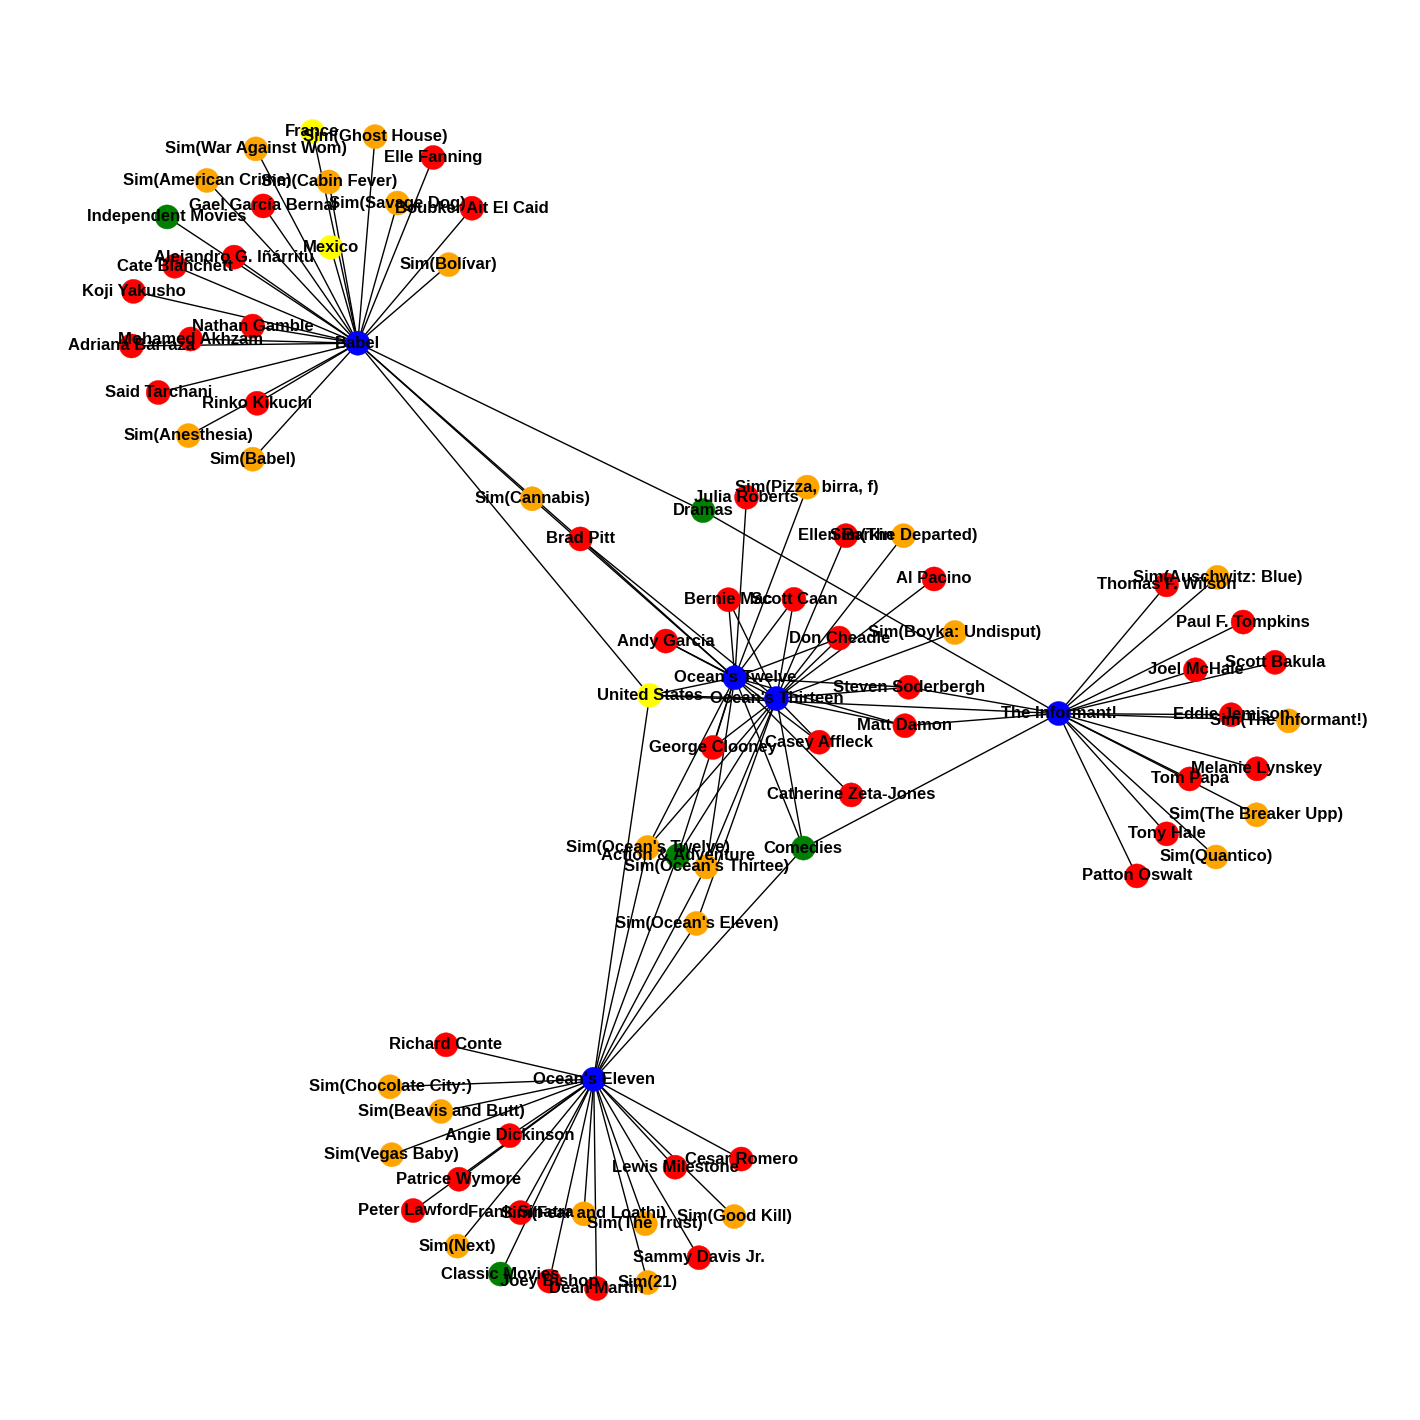

In [19]:
reco=list(result1.index[:4].values)
reco.extend(["Ocean's Twelve"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)